In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/amazon-google-reduced/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','amazon-google-reduced')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

data['train_2']['price'] = data['train_2']['price'].apply(hp.str_to_num)
data['val_2']['price'] = data['val_2']['price'].apply(hp.str_to_num)
data['test_2']['price'] = data['test_2']['price'].apply(hp.str_to_num)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/amazon-google-reduced/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model 

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/amazon-google-reduced/glove-300.matrix.npy',
                        text_columns = ['name', 'description'],
                        numeric_columns = [],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine', 'inverse_l1', 'inverse_l2'],
                        text_compositions=['average'],
                        numeric_sim_metrics=[],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=False)

Number of inputs to dense layer: 6


# Train model 

In [55]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=128,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 105040 samples, validate on 13130 samples
Epoch 1/1
105040/105040 [==============================] - 13s 124us/step - loss: 0.0152 - acc: 0.9953 - val_loss: 0.0159 - val_acc: 0.9954


# Learning curves

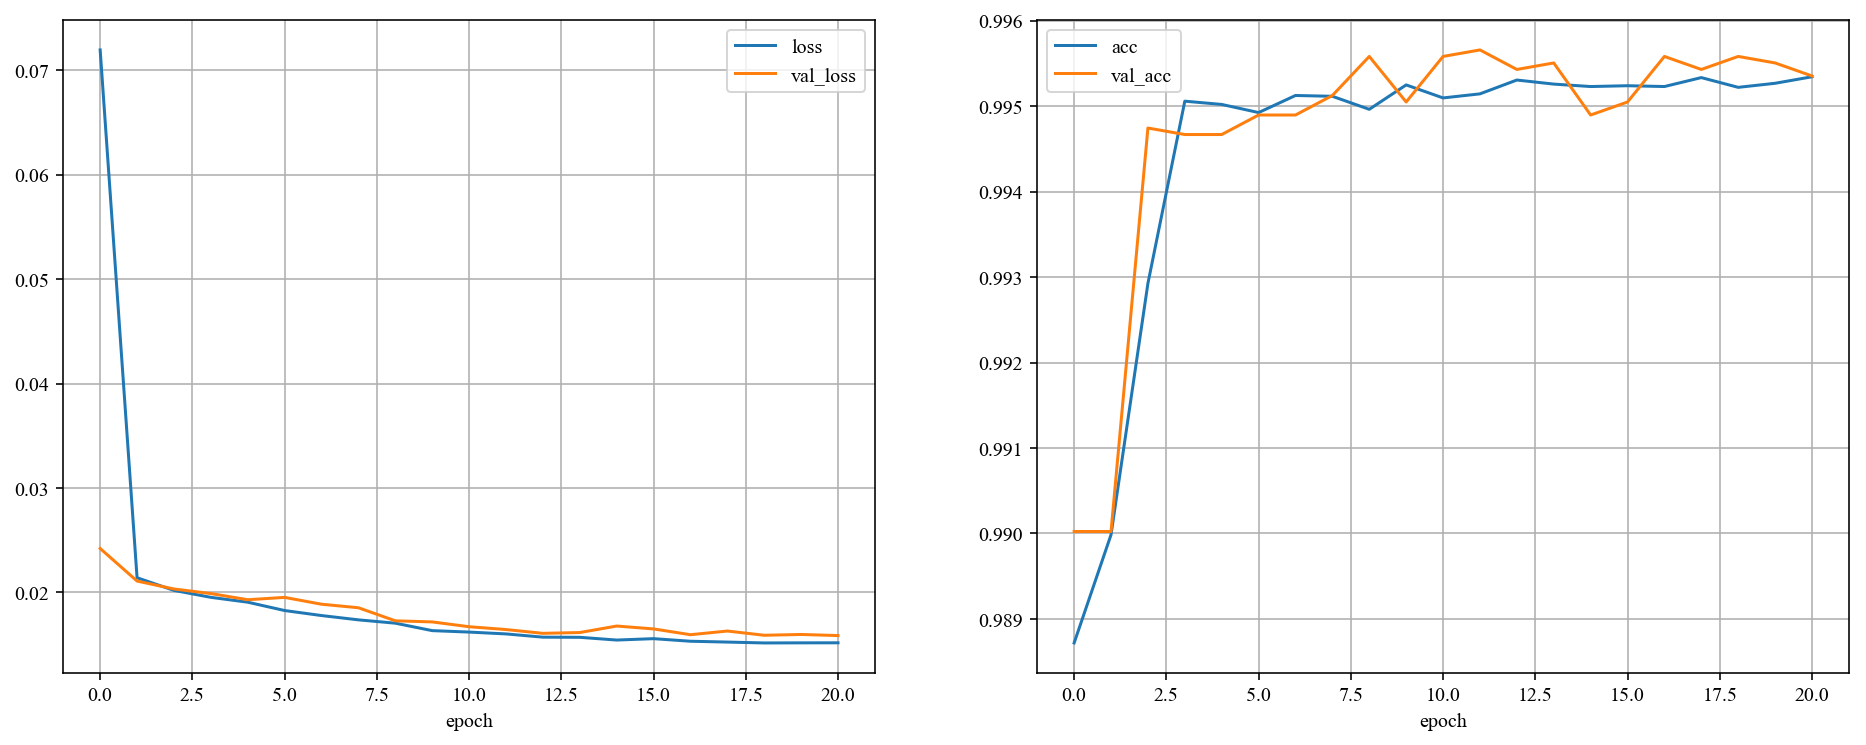

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [57]:
y_val_pred = model.predict(X_val)[:,1]
y_val_ = data['val_y'].values.squeeze()

In [58]:
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     12999
          1       0.81      0.70      0.75       131

avg / total       1.00      1.00      1.00     13130

[[12977    22]
 [   39    92]]


In [41]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['name', 'description']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)

In [42]:
df_examine.sample(10)

,id1,name,description,price,id2,name,description,price
1482,b0007q7mg2,upg rumba edition level,upg rumba edition level units,0.00,http://www.google.com/base/feeds/snippets/13029285540855383313,rumba edition upgrade license user volume level,usually ships 24 hours rumba product family provides users secure access applications data residing virtually any host system latest windows desktops including windows xp,106.48
13073,b000icpfmi,knowledge adventure jumpstart 1st grade,jumpstart 1st grade teaches essential skills school product information join frankie his friends an interactive classroom filled animation take field trips beach read 50 illustrated stories interactive books help flores all discover 18 activities teaching geography science early math reading comprehension music more if want first grader focus reading more intensively get jumpstart 1st grade reading jumpstart elementary learning system based nationally recommended curricula actual teacher lesson result an incredible variety activities that make learning choosing best educational child can be jumpstart system makes it easy by taking what children learn school organizing it by grade so real learning reinforced every jumpstart helpful animated friends encourage child explore an amazing variety fun 18 interactive learning modules jumpstart 1st grade has three times more activities than typical education skills learned reading additi...,0.00,http://www.google.com/base/feeds/snippets/14325412592062687221,jumpstart 1st grade jc,jumpstart 1st grade teaches essential skills school,9.90
3009,b000hhvb9k,encore monopoly here now,monopoly here now extends fun classic board game by taking out atlantic city letting buy some best modern real world has changed amazingly over last 70 years this special anniversary edition celebrates monopoly new spin old choose range new movers including mobile phone roller blade even cheeseburger rent has rocketed sky high much more recognisable can build property covent garden visit london eye make millions,19.95,http://www.google.com/base/feeds/snippets/9852496278444342781,encore 11180 monopoly here now win 98 me 2000 xp,encore 11180 this special anniversary edition celebrates 70 years world most popular board game modern day equivalent traditional system requirements operating system windows 98 me xp processor pentium,18.97
8804,b000f7bps4,palo alto palo alto marketing plan pro,marketing plan pro easiest way create practical successful marketing if need finish plan accomplish goal most professional most efficient way possible marketing plan pro can produce professional plan that will be respected by business colleagues just few five unique outlines new plan setup wizard make it easy tailor marketing plan pro fit develop best strategy business define positioning impress audience automatic professional its expert guidance handle budgeting track performance attain plan manage marketing schedule budget implement strategy better option two full years monthly financial reporting an option quarterly reports tools help users create mission statement executive summary swot analysis wizard enables marketer create practical plan open sample marketing plan view plan setup summary see if it good match can then make specific changes sample tailor needs included free 22 immutable laws bran...,179.00,http://www.google.com/base/feeds/snippets/12516109834871224117,palo alto palo alto marketing plan pro complete product business planning user complete product standard pc,palo alto marketing plan plan pro selling marketing planning providing everything need produce profession marketing plan that gets enclosed no download only system,149.97
3207,b000bx5ggy,apple computer apple shake visual effects,shake lets leverage creative work producing final cut studio even tight production shake provides only compositing complete toolset both single artists visual effects facilities combination produces world most celebrated visual use shake create convincing photorealisti

# Save model and histories 

In [49]:
pd.DataFrame(histories).to_csv('../data/histories/amazon-google-base-1-allsim.csv', index=False)
model.save_weights('../data/models/amazon-google-base-1-allsim')

# Test model 

In [4]:
model.load_weights('../data/models/amazon-google-base-1-allsim')
y_test_pred = model.predict(X_test)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99685   0.99846   0.99766     13013
          1    0.79167   0.64957   0.71362       117

avg / total    0.99503   0.99535   0.99513     13130

[[12993    20]
 [   41    76]]
